In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from matplotlib import pyplot as plt
from IPython.display import clear_output
from matplotlib.colors import TABLEAU_COLORS

sys.path.append('..')
from notebook_utils import Data, train, run_study, test_vanilla, test_uncertain

sys.path.append('../../..')
from uncertain.pairwise_ranking.MF import bprMF, UncertainMF, PretrainedUncertainMF
from uncertain.extras import Resample

if os.path.isfile('data.pkl'):
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
    print(f'Printerest data loaded: {data.n_user} users, {data.n_item} items.')
    print(f'{len(data.train)} train, {len(data.val)} validation and {len(data.test)} test interactions.')
else:
    a = pd.read_csv('pinterest-20.train.rating.txt', sep='\t', header=None)
    b = pd.read_csv('pinterest-20.test.rating.txt', sep='\t', header=None)
    data = pd.concat([a, b], ignore_index=True).drop(columns=[2, 3])
    data.columns = ['user', 'item']
    data = Data(data)
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f, protocol=4)
        
base_conf = {'embedding_dim':10, 'lr':0, 'weight_decay':0}
trials = 0 ## 0 for eval only mode

Printerest data loaded: 55187 users, 9916 items.
921169 train, 280706 validation and 298934 test interactions.


# MF-BPR

In [2]:
name = 'MF-BPR'
def init_model(**kwargs):
    return bprMF(data.n_user, data.n_item, **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 2**8, 2**10)
    params = {'embedding_dim': trial.suggest_int('dim', 200, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-5, 1e-3)}
    '''
    'weight_decay': (trial.suggest_float('wd_user', 1e-4, 1e-2), 
                     trial.suggest_float('wd_item', 1e-4, 1e-2), 
                     trial.suggest_float('wd_neg_item', 1e-4, 1e-2))
    '''
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
baseline = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(baseline, data, max_k=10, name=name)

clear_output(wait=True)
print(best_runs.user_attrs_filename.iloc[0])
print(results)
best_runs

/home/vcoscrato/Documents/RecSys/MF/tests/Pairwise/Pinterest/checkpoints/MF-BPR/bs = 631-embedding_dim=200-lr=0.00010617814604775413-weight_decay=0.0006869287399666869-epoch=129-val_likelihood=0.9442611932754517.ckpt
{'FCP': 0.9602219888002034, 'MAP': array([0.0604309 , 0.08391469, 0.09544519, 0.10278589, 0.10763468,
       0.11121956, 0.11385035, 0.11572502, 0.11706415, 0.11794166],
      dtype=float32), 'Recall': array([0.01106845, 0.02081889, 0.02882847, 0.03653536, 0.04381863,
       0.05095472, 0.05776256, 0.06396703, 0.07001328, 0.07567851],
      dtype=float32)}


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
2,2,0.944214,2022-06-28 21:13:25.571522,2022-06-28 21:50:30.458118,0 days 00:37:04.886596,631,200,0.000106,0.000687,/home/vcoscrato/Documents/RecSys/MF/tests/Pair...,COMPLETE
4,4,0.942177,2022-06-28 22:03:49.945982,2022-06-28 22:16:27.848819,0 days 00:12:37.902837,729,200,0.000387,0.000895,/home/vcoscrato/Documents/RecSys/MF/tests/Pair...,COMPLETE
0,0,0.941921,2022-06-28 20:55:26.074154,2022-06-28 21:02:41.411608,0 days 00:07:15.337454,856,200,0.000547,0.000860,/home/vcoscrato/Documents/RecSys/MF/tests/Pair...,COMPLETE
3,3,0.941276,2022-06-28 21:50:30.459146,2022-06-28 22:03:49.944986,0 days 00:13:19.485840,356,200,0.000960,0.000490,/home/vcoscrato/Documents/RecSys/MF/tests/Pair...,COMPLETE
1,1,0.939690,2022-06-28 21:02:41.412660,2022-06-28 21:13:25.570583,0 days 00:10:44.157923,349,200,0.000917,0.000714,/home/vcoscrato/Documents/RecSys/MF/tests/Pair...,COMPLETE


# GMF-GPR

/home/vcoscrato/Documents/RecSys/MF/tests/Pairwise/Pinterest/checkpoints/UMF-GPR-notailchasing/bs = 753-embedding_dim=200-embedding_dim_var=40-lr=0.0001422993864210535-weight_decay=9.549884706388945e-05-epoch=54-val_likelihood=0.9587447643280029.ckpt
{'FCP': 0.959208387135622, 'CP unc': 0.31661987, 'DP unc': 0.2509799, 'PUR': 1.2615348, 'corr_usup': -0.07401953213258053, 'corr_isup': -0.47749727599430913, 'MAP': array([0.05782159, 0.08026347, 0.09228925, 0.0996385 , 0.1046865 ,
       0.10844254, 0.11083263, 0.11286519, 0.11418802, 0.11509341],
      dtype=float32), 'Recall': array([0.01065513, 0.01977233, 0.02793613, 0.03549549, 0.0426539 ,
       0.04965496, 0.05606527, 0.06228584, 0.06798255, 0.07366717],
      dtype=float32), 'UAC': 0.19644863022239786, 'URI': -0.028427504003047943, 'MAP-covered': array([0.11509342, 0.10400628, 0.097221  , 0.09554898, 0.09181059,
       0.08730632, 0.08187695, 0.07838363, 0.07413073, 0.06778607])}


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_dim_var,params_lr,params_wd,user_attrs_filename,state
14,14,0.958745,2022-06-29 07:51:13.066043,2022-06-29 08:36:20.050068,0 days 00:45:06.984025,753,200,40,0.000142,0.000095,/home/vcoscrato/Documents/RecSys/MF/tests/Pair...,COMPLETE
10,10,0.958697,2022-06-29 05:08:20.928095,2022-06-29 05:46:02.451543,0 days 00:37:41.523448,764,200,37,0.000132,0.000065,/home/vcoscrato/Documents/RecSys/MF/tests/Pair...,COMPLETE
18,18,0.958681,2022-06-29 10:51:40.206301,2022-06-29 11:29:25.098309,0 days 00:37:44.892008,1015,200,43,0.000163,0.000099,/home/vcoscrato/Documents/RecSys/MF/tests/Pair...,COMPLETE
12,12,0.958501,2022-06-29 06:45:18.594122,2022-06-29 07:17:37.631741,0 days 00:32:19.037619,748,200,39,0.000234,0.000064,/home/vcoscrato/Documents/RecSys/MF/tests/Pair...,COMPLETE
13,13,0.958423,2022-06-29 07:17:37.632816,2022-06-29 07:51:13.064979,0 days 00:33:35.432163,749,200,37,0.000185,0.000059,/home/vcoscrato/Documents/RecSys/MF/tests/Pair...,COMPLETE


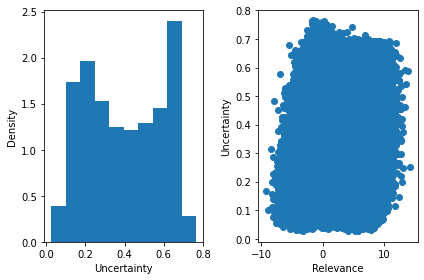

In [3]:
name = 'UMF-GPR-notailchasing'

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 2**8, 2**10)
    params = {'embedding_dim': trial.suggest_int('dim', 200, 200),
              'embedding_dim_var': trial.suggest_int('dim_var', 5, 50),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-6, 1e-4)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = UncertainMF(data.n_user, data.n_item, **params)
    
    # Freeze uncertainty
    for param in model.user_var.parameters():
        param.requires_grad = False
    for param in model.item_var.parameters():
        param.requires_grad = False
     
    _, path = train(model, data, path='checkpoints/' + name, name=params_str)
    model.load_from_checkpoint(path)
    
    # Unfreeze uncertainty
    for param in model.user_var.parameters():
        param.requires_grad = True
    for param in model.item_var.parameters():
        param.requires_grad = True
        
    # Freeze mean
    for param in model.user_mean.parameters():
        param.requires_grad = False
    for param in model.item_mean.parameters():
        param.requires_grad = False
    
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = UncertainMF(data.n_user, data.n_item, 1, 1, 1, 1).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
print(best_runs.user_attrs_filename.iloc[0])
print(results)
best_runs

/home/vcoscrato/Documents/RecSys/MF/tests/Pairwise/Pinterest/checkpoints/UMF-GPR-notailchasing/bs = 764-embedding_dim=200-embedding_dim_var=37-lr=0.0001316978711939181-weight_decay=6.504806477856384e-05-epoch=54-val_likelihood=0.9586969017982483.ckpt
{'FCP': 0.9592016966955916, 'CP unc': 0.31920803, 'DP unc': 0.25694713, 'PUR': 1.2423102, 'corr_usup': -0.059672827946633, 'corr_isup': -0.4627979962949824, 'MAP': array([0.0574773 , 0.07815246, 0.09002422, 0.09763068, 0.1024007 ,
       0.10588197, 0.10845641, 0.11029998, 0.11153471, 0.11253324],
      dtype=float32), 'Recall': array([0.01059036, 0.019067  , 0.0270515 , 0.03455961, 0.04142137,
       0.04811835, 0.05472579, 0.06066553, 0.06651516, 0.07225421],
      dtype=float32), 'UAC': 0.18193408209472062, 'URI': 0.007409377954900265, 'MAP-covered': array([0.11253324, 0.10084251, 0.09435612, 0.09340222, 0.09107528,
       0.08749237, 0.0843716 , 0.08236716, 0.07872677, 0.07351825])}


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_dim_var,params_lr,params_wd,user_attrs_filename,state
14,14,0.958745,2022-06-29 07:51:13.066043,2022-06-29 08:36:20.050068,0 days 00:45:06.984025,753,200,40,0.000142,0.000095,/home/vcoscrato/Documents/RecSys/MF/tests/Pair...,COMPLETE
10,10,0.958697,2022-06-29 05:08:20.928095,2022-06-29 05:46:02.451543,0 days 00:37:41.523448,764,200,37,0.000132,0.000065,/home/vcoscrato/Documents/RecSys/MF/tests/Pair...,COMPLETE
18,18,0.958681,2022-06-29 10:51:40.206301,2022-06-29 11:29:25.098309,0 days 00:37:44.892008,1015,200,43,0.000163,0.000099,/home/vcoscrato/Documents/RecSys/MF/tests/Pair...,COMPLETE
12,12,0.958501,2022-06-29 06:45:18.594122,2022-06-29 07:17:37.631741,0 days 00:32:19.037619,748,200,39,0.000234,0.000064,/home/vcoscrato/Documents/RecSys/MF/tests/Pair...,COMPLETE
13,13,0.958423,2022-06-29 07:17:37.632816,2022-06-29 07:51:13.064979,0 days 00:33:35.432163,749,200,37,0.000185,0.000059,/home/vcoscrato/Documents/RecSys/MF/tests/Pair...,COMPLETE


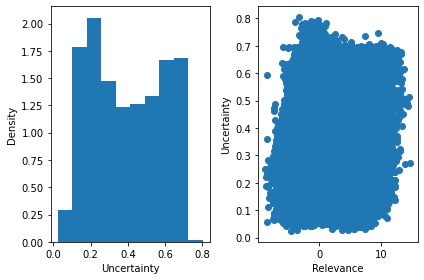

In [4]:
study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = UncertainMF(data.n_user, data.n_item, 1, 1, 1, 1).load_from_checkpoint(best_runs.user_attrs_filename.iloc[1])
results = test_uncertain(model, data, max_k=10, name='UMF-GPR-run1')

clear_output(wait=True)
print(best_runs.user_attrs_filename.iloc[1])
print(results)
best_runs

In [5]:
# Load results
results = {}
for key in os.listdir('results'):
    results[key.replace('.pkl', '')] = pickle.load(open(os.path.join('results', key), 'rb'))
order = ['MF-BPR', 'UMF-GPR-notailchasing', 'UMF-GPR-run1']
results = pd.DataFrame([results[key] for key in order], index=order)

# Plot aestetics
colors = [c for c in list(TABLEAU_COLORS)] + ['k', 'b', 'g', 'r']
colors = {k:c for k, c in zip(results.index, colors)}
lines = ['o', 'v', '^', '<', '>', 's', 'p', '+', 'x', '*']
lines = {k: '-' + l for k, l, in zip(results, lines)}

# Results
results[['FCP', 'CP unc', 'DP unc', 'PUR', 'URI', 'UAC']]

,FCP,CP unc,DP unc,PUR,URI,UAC
MF-BPR,0.960222,NaN,NaN,NaN,NaN,NaN
UMF-GPR-notailchasing,0.959208,0.316620,0.250980,1.261535,-0.028428,0.196449
UMF-GPR-run1,0.959202,0.319208,0.256947,1.242310,0.007409,0.181934


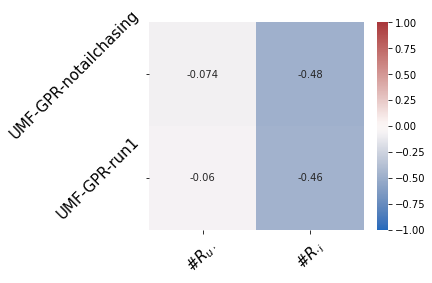

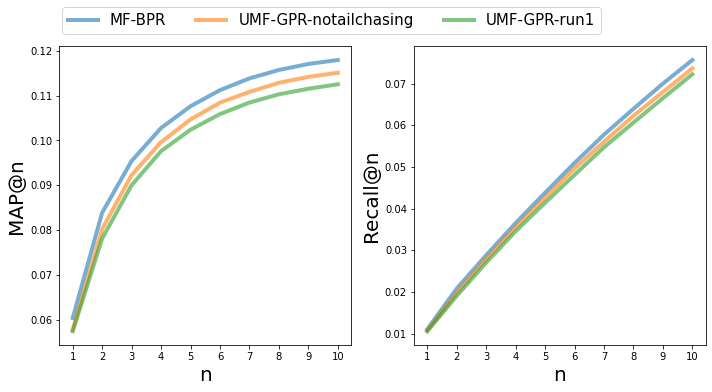

In [6]:
## Correlation plot
corr = results.drop('MF-BPR', axis=0).filter(like='corr', axis=1)
corr.columns = [r'#$R_{u\cdot}$', r'#$R_{\cdot i}$']
sns.heatmap(corr.round(3), annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.xticks(rotation=45, fontsize=15)
plt.yticks(rotation=45, fontsize=15)
plt.tight_layout()
plt.savefig('plots/corr.pdf')

## Top-K accuracy metrics
f, ax = plt.subplots(figsize=(10, 5), ncols=2)
for index, row in results.iterrows():
    ax[0].plot(np.arange(1, 11), row['MAP'], '-', color=colors[index], label=index, linewidth=4, alpha=0.6)
    ax[1].plot(np.arange(1, 11), row['Recall'], '-', color=colors[index], label=index, linewidth=4, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('n', fontsize=20)
ax[0].set_ylabel('MAP@n', fontsize=20)
ax[1].set_xticks(np.arange(1, 11))
ax[1].set_xlabel('n', fontsize=20)
ax[1].set_ylabel('Recall@n', fontsize=20)
handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, labels, fontsize=15, ncol=3, bbox_to_anchor=(0.85, 1.1))
f.tight_layout()
f.savefig('plots/accuracy.pdf', bbox_inches="tight")

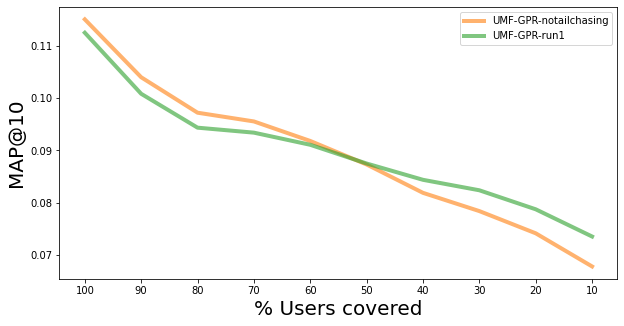

In [7]:
f, ax = plt.subplots(figsize=(10, 5))
for index, row in results.drop(['MF-BPR'], axis=0).iterrows():
    ax.plot(np.arange(1, 11), row['MAP-covered'], '-', color=colors[index], label=index, linewidth=4, alpha=0.6)
ax.set_xticks(np.arange(1, 11))
ax.set_xticklabels(np.linspace(100, 10, 10).astype(np.int8))
ax.set_xlabel('% Users covered', fontsize=20)
ax.set_ylabel('MAP@10', fontsize=20)
ax.legend()